In [485]:
import pandas as pd
import streamlit as st
import duckdb
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pmdarima import auto_arima
from meteostat import Point, Hourly
import holidays
import warnings
warnings.filterwarnings("ignore")
def load_data():
    con = duckdb.connect(database=':memory:', read_only=False)
    path=r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data\combined_sampled_data.parquet"
    df = con.execute(f"SELECT * FROM '{path}'").df()
    return df
data = load_data()


In [486]:
data=data[data['total_amount']>0]
data=data[data['trip_distance']<=100]
data['Date']=data['tpep_pickup_datetime'].dt.date
data['Hour']=data['tpep_pickup_datetime'].dt.hour
data['Date']=pd.to_datetime(data['Date'])
data=data[(data['Date'].dt.year)==2025]

In [487]:
data['passenger_count'].fillna(0, inplace=True)
data['RatecodeID'].fillna(-1, inplace=True)
data['store_and_fwd_flag'].fillna('N', inplace=True)
data['congestion_surcharge'].fillna(0, inplace=True)
data['Airport_fee'].fillna(0, inplace=True)

In [488]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,0.5,5.45,0.0,1.0,32.75,2.5,0.0,0.00,2025-01-08,12
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.5,3.02,0.0,1.0,18.10,0.0,0.0,0.00,2025-01-12,15
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,0.5,0.00,0.0,1.0,18.25,2.5,0.0,0.75,2025-01-22,10
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,0.5,0.00,0.0,1.0,17.95,2.5,0.0,0.75,2025-01-21,19
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,0.5,2.82,0.0,1.0,12.22,0.0,0.0,0.00,2025-01-17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023615,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,0.5,2.30,0.0,1.0,13.85,2.5,0.0,0.75,2025-10-26,21
4023616,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,0.5,0.00,0.0,1.0,9.80,2.5,0.0,0.00,2025-10-04,12
4023617,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,0.5,0.00,0.0,1.0,7.23,0.0,0.0,0.75,2025-10-21,20
4023618,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,0.5,4.12,0.0,1.0,24.72,0.0,0.0,0.00,2025-10-04,15


In [489]:
location = Point(40.7128, -74.0060)  # NYC example
weather = Hourly(
    location,
    start=data['Date'].min(),
    end=data['Date'].max()
).fetch().reset_index()

weather = weather[['time', 'temp', 'prcp', 'wspd']]
weather.rename(columns={'time': 'Date'}, inplace=True)

df = data.merge(weather, on='Date', how='left')

In [490]:
us_holidays = holidays.US(years=df['Date'].dt.year.unique())
df['is_holiday'] = df['Date'].isin(us_holidays).astype(int)

In [491]:
df['is_festive_window'] = 0

for holiday_date in us_holidays:
    festive_range = pd.date_range(
        start=pd.to_datetime(holiday_date) - pd.Timedelta(days=2),
        end=pd.to_datetime(holiday_date) + pd.Timedelta(days=2)
    )
    df.loc[df['Date'].isin(festive_range), 'is_festive_window'] = 1

In [492]:
import requests

def get_nyc_weather(start, end):
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude=40.7128&longitude=-74.0060"
        f"&start_date={start}&end_date={end}"
        "&daily=temperature_2m_mean,precipitation_sum"
        "&timezone=America/New_York"
    )
    return requests.get(url).json()

weather_json = get_nyc_weather(
    df['Date'].min().strftime('%Y-%m-%d'),
    df['Date'].max().strftime('%Y-%m-%d')
)

In [493]:
weather_df = pd.DataFrame({
    'Date': pd.to_datetime(weather_json['daily']['time']),
    'avg_temp': weather_json['daily']['temperature_2m_mean'],
    'precipitation': weather_json['daily']['precipitation_sum']
})

In [494]:
df = df.merge(weather_df, on='Date', how='left')

In [495]:
df['is_rainy'] = (df['precipitation'] > 5).astype(int)
df['is_cold'] = (df['avg_temp'] < 5).astype(int)
df['is_hot'] = (df['avg_temp'] > 30).astype(int)

In [496]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,temp,prcp,wspd,is_holiday,is_festive_window,avg_temp,precipitation,is_rainy,is_cold,is_hot
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,-1.1,0.0,7.6,0,0,-4.5,0.0,0,1,0
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.0,0.0,0.0,0,0,0.5,0.0,0,1,0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,-7.8,0.0,18.4,0,1,-12.0,0.0,0,1,0
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,-5.6,0.0,20.5,0,1,-11.4,0.4,0,1,0
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,-1.7,0.0,13.0,0,0,-0.7,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,14.0,0.0,7.0,0,0,10.0,0.1,0,0,0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,15.0,0.0,17.0,0,0,13.5,0.1,0,0,0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0


In [497]:
def load_exogenous_data():
    path=r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data/sarimax_exogenous_Data_with_resample.csv"
    df = pd.read_csv(path)
    return df

In [498]:
df = load_exogenous_data()

In [499]:
df

,tpep_pickup_datetime,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax
0,2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,-159.045861
1,2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,860.494735
2,2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,711.974726
3,2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,482.068727
4,2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,250.494437
...,...,...,...,...,...,...,...,...,...,...,...
7291,2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1042.033278
7292,2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1103.275678
7293,2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1025.275843
7294,2025-10-31 22:00:00,1072,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1024.224383


In [500]:
df['lag_1'] = df['Trips'].shift(1)
df['lag_24'] = df['Trips'].shift(24)
df['lag_168'] = df['Trips'].shift(168)  # weekly

In [501]:
df['rolling_mean_24'] = df['Trips'].rolling(24).mean()
df['rolling_std_24'] = df['Trips'].rolling(24).std()


In [502]:
df

,tpep_pickup_datetime,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24
0,2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,-159.045861,NaN,NaN,NaN,NaN,NaN
1,2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,860.494735,694.0,NaN,NaN,NaN,NaN
2,2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,711.974726,814.0,NaN,NaN,NaN,NaN
3,2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,482.068727,656.0,NaN,NaN,NaN,NaN
4,2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,250.494437,417.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1042.033278,1137.0,1017.0,1020.0,652.750000,315.398609
7292,2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1103.275678,1155.0,865.0,830.0,660.083333,322.514026
7293,2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1025.275843,1041.0,954.0,881.0,665.708333,328.975680
7294,2025-10-31 22:00:00,1072,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1024.224383,1089.0,903.0,889.0,672.750000,336.009220


In [503]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

In [504]:
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)


In [505]:
df['dayofweek'].value_counts()

dayofweek
2    1056
3    1056
4    1056
5    1032
6    1032
0    1032
1    1032
Name: count, dtype: int64

In [506]:
df = df.dropna()

In [507]:
df

,tpep_pickup_datetime,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,hour,dayofweek,is_weekend
168,2025-01-08 00:00:00,120,-1.1,0.0,7.6,0.0,0.0,0.0,1.0,0.0,37.490941,206.0,106.0,694.0,411.458333,256.076751,0,2,0
169,2025-01-08 01:00:00,39,-1.1,0.0,7.6,0.0,0.0,0.0,1.0,0.0,73.230096,120.0,39.0,814.0,411.458333,256.076751,1,2,0
170,2025-01-08 02:00:00,19,-1.1,0.0,7.6,0.0,0.0,0.0,1.0,0.0,12.068286,39.0,20.0,656.0,411.416667,256.143288,2,2,0
171,2025-01-08 03:00:00,18,-1.1,0.0,7.6,0.0,0.0,0.0,1.0,0.0,5.524301,19.0,19.0,417.0,411.375000,256.209970,3,2,0
172,2025-01-08 04:00:00,22,-1.1,0.0,7.6,0.0,0.0,0.0,1.0,0.0,29.357711,18.0,20.0,271.0,411.458333,256.077430,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1042.033278,1137.0,1017.0,1020.0,652.750000,315.398609,19,4,0
7292,2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1103.275678,1155.0,865.0,830.0,660.083333,322.514026,20,4,0
7293,2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1025.275843,1041.0,954.0,881.0,665.708333,328.975680,21,4,0
7294,2025-10-31 22:00:00,1072,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1024.224383,1089.0,903.0,889.0,672.750000,336.009220,22,4,0


In [508]:
df.set_index('tpep_pickup_datetime',inplace=True)

In [509]:
target = 'Trips'

features = [
    'lag_1', 'lag_24', 'lag_168',
    'rolling_mean_24', 'rolling_std_24',
    'hour', 'dayofweek', 'is_weekend',
    'temp', 'prcp', 'wspd',
    'is_holiday', 'is_festive_window'
]

X = df[features]
y = df[target]


In [510]:
X

,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,hour,dayofweek,is_weekend,temp,prcp,wspd,is_holiday,is_festive_window
tpep_pickup_datetime,,,,,,,,,,,,,
2025-01-08 00:00:00,206.0,106.0,694.0,411.458333,256.076751,0,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 01:00:00,120.0,39.0,814.0,411.458333,256.076751,1,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 02:00:00,39.0,20.0,656.0,411.416667,256.143288,2,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 03:00:00,19.0,19.0,417.0,411.375000,256.209970,3,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 04:00:00,18.0,20.0,271.0,411.458333,256.077430,4,2,0,-1.1,0.0,7.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1137.0,1017.0,1020.0,652.750000,315.398609,19,4,0,17.0,2.3,9.0,0.0,0.0
2025-10-31 20:00:00,1155.0,865.0,830.0,660.083333,322.514026,20,4,0,17.0,2.3,9.0,0.0,0.0
2025-10-31 21:00:00,1041.0,954.0,881.0,665.708333,328.975680,21,4,0,17.0,2.3,9.0,0.0,0.0


In [511]:
split_date = pd.to_datetime('2025-09-01')  # Mid-year split for 2025-only data

mask_train = X.index < split_date
mask_test = X.index >= split_date

X_train = X[mask_train].copy()
X_test = X[mask_test].copy()
y_train = y[mask_train].copy()
y_test = y[mask_test].copy()

In [512]:
y_train

tpep_pickup_datetime
2025-01-08 00:00:00    120
2025-01-08 01:00:00     39
2025-01-08 02:00:00     19
2025-01-08 03:00:00     18
2025-01-08 04:00:00     22
                      ... 
2025-08-31 19:00:00    575
2025-08-31 20:00:00    611
2025-08-31 21:00:00    540
2025-08-31 22:00:00    571
2025-08-31 23:00:00    548
Name: Trips, Length: 5615, dtype: int64

In [513]:
X_train

,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,hour,dayofweek,is_weekend,temp,prcp,wspd,is_holiday,is_festive_window
tpep_pickup_datetime,,,,,,,,,,,,,
2025-01-08 00:00:00,206.0,106.0,694.0,411.458333,256.076751,0,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 01:00:00,120.0,39.0,814.0,411.458333,256.076751,1,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 02:00:00,39.0,20.0,656.0,411.416667,256.143288,2,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 03:00:00,19.0,19.0,417.0,411.375000,256.209970,3,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 04:00:00,18.0,20.0,271.0,411.458333,256.077430,4,2,0,-1.1,0.0,7.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31 19:00:00,717.0,718.0,546.0,468.250000,206.115259,19,6,1,23.0,0.0,13.0,0.0,1.0
2025-08-31 20:00:00,575.0,629.0,524.0,467.500000,205.536837,20,6,1,23.0,0.0,13.0,0.0,1.0
2025-08-31 21:00:00,611.0,643.0,516.0,463.208333,202.769730,21,6,1,23.0,0.0,13.0,0.0,1.0


In [514]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

In [515]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [516]:
from xgboost import XGBRegressor

In [520]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [521]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"XGBoost_MAE {mae:.2f}")
print(f"XGBoost_MSE {mse:.2f}")
print(f"XGBoost_RMSE {rmse:.2f}")


XGBoost_MAE 34.91
XGBoost_MSE 2287.48
XGBoost_RMSE 47.83


In [522]:
y_pred = xgb_model.predict(X_test)

y_pred_series = pd.Series(
    y_pred,
    index=y_test.index,
    name="XGBoost_Predicted"
)


In [524]:
y_pred = y_pred.ravel()


In [526]:
y_pred = pd.Series(
    y_pred,
    index=y_test.index,
    name="Predicted")

In [527]:
y_pred =pd.DataFrame(y_pred,columns=['Predicted'])

In [530]:
results_df = pd.concat([y_test, y_pred], axis=1)

In [532]:
results_df.isnull().sum()

Trips        0
Predicted    0
dtype: int64

In [533]:
y_test= y_test[y_test.index.month==1]

In [534]:
y_test

Series([], Name: Trips, dtype: int64)

In [535]:
y_pred = pd.DataFrame(y_pred)

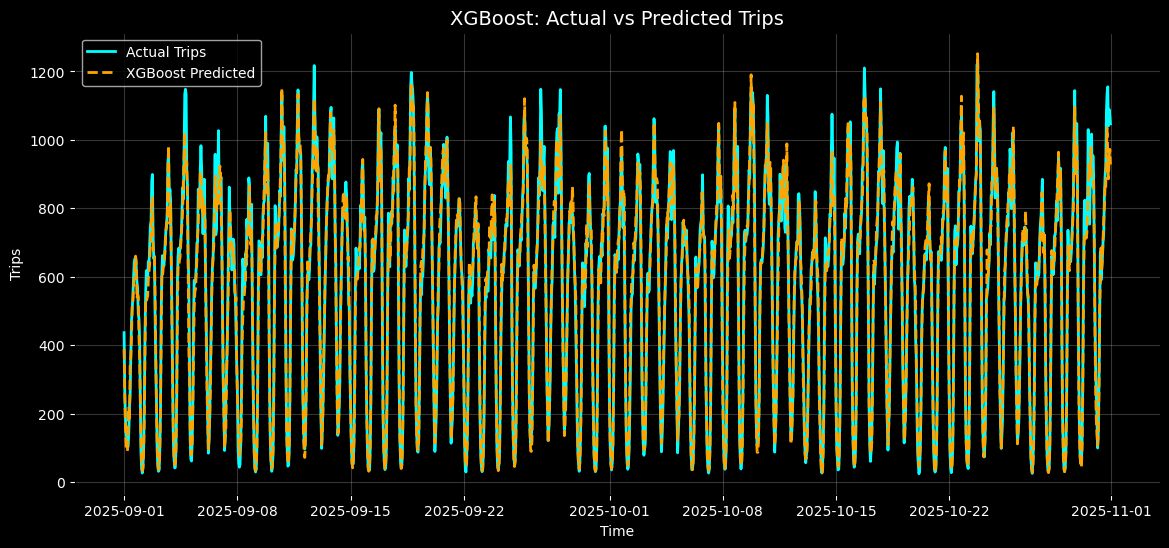

In [536]:
%matplotlib inline
import matplotlib.pyplot as plt
import streamlit as st

fig, ax = plt.subplots(figsize=(14,6))

# Dark background (optional – remove if you want default)
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.plot(
    results_df.index,
    results_df['Trips'],
    label="Actual Trips",
    color="cyan",
    linewidth=2
)

ax.plot(
    results_df.index,
    results_df['Predicted'],
    label="XGBoost Predicted",
    color="orange",
    linestyle="--",
    linewidth=2
)

ax.set_title("XGBoost: Actual vs Predicted Trips", color="white", fontsize=14)
ax.set_xlabel("Time", color="white")
ax.set_ylabel("Trips", color="white")

ax.tick_params(colors="white")
ax.legend(facecolor="black", labelcolor="white")
ax.grid(alpha=0.3)

# st.pyplot(fig)
plt.show()


In [537]:
results_df

,Trips,Predicted
tpep_pickup_datetime,,
2025-09-01 00:00:00,437,389.398346
2025-09-01 01:00:00,264,251.209244
2025-09-01 02:00:00,189,161.736816
2025-09-01 03:00:00,137,99.202332
2025-09-01 04:00:00,132,91.405785
...,...,...
2025-10-31 19:00:00,1155,965.857422
2025-10-31 20:00:00,1041,886.297058
2025-10-31 21:00:00,1089,949.352783


In [538]:
from sklearn.metrics import root_mean_squared_error

In [539]:
xg_mae= mean_absolute_error(results_df['Trips'],results_df['Predicted'])
xg_mse= mean_squared_error(results_df['Trips'],results_df['Predicted'])
xg_rmse = root_mean_squared_error(results_df['Trips'],results_df['Predicted'])

print(f"XGB MAE {xg_mae:.2f}")
print(f"XGB MSE {xg_mse:.2f}")
print(f"XGB RMSE {xg_rmse:.2f}")

XGB MAE 34.91
XGB MSE 2287.48
XGB RMSE 47.83


In [540]:
# xg_mae= mean_absolute_error(y_test,y_pred)
# xg_mse= mean_squared_error(y_test,y_pred)
# xg_rmse = root_mean_squared_error(y_test,y_pred)

# print(f"XGB MAE {xg_mae:.2f}")
# print(f"XGB MSE {xg_mse:.2f}")
# print(f"XGB RMSE {xg_rmse:.2f}")

In [541]:
xgb_model.feature_importances_

array([0.22860253, 0.03900818, 0.60612506, 0.00576346, 0.01294553,
       0.04031801, 0.01396425, 0.01254545, 0.00613967, 0.0047077 ,
       0.00489348, 0.01188001, 0.01310675], dtype=float32)

In [542]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)


In [543]:
feature_importance

,Feature,Importance
2,lag_168,0.606125
0,lag_1,0.228603
5,hour,0.040318
1,lag_24,0.039008
6,dayofweek,0.013964
12,is_festive_window,0.013107
4,rolling_std_24,0.012946
7,is_weekend,0.012545
11,is_holiday,0.011880
8,temp,0.006140


DeltaGenerator()

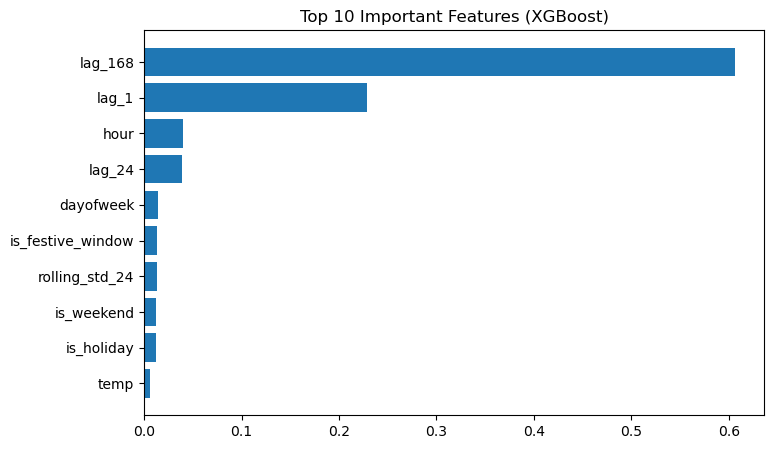

In [544]:
fig, ax = plt.subplots(figsize=(8,5))

ax.barh(
    feature_importance["Feature"][:10][::-1],
    feature_importance["Importance"][:10][::-1]
)

ax.set_title("Top 10 Important Features (XGBoost)")
st.pyplot(fig)


In [545]:
X_train

,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,hour,dayofweek,is_weekend,temp,prcp,wspd,is_holiday,is_festive_window
tpep_pickup_datetime,,,,,,,,,,,,,
2025-01-08 00:00:00,206.0,106.0,694.0,411.458333,256.076751,0,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 01:00:00,120.0,39.0,814.0,411.458333,256.076751,1,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 02:00:00,39.0,20.0,656.0,411.416667,256.143288,2,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 03:00:00,19.0,19.0,417.0,411.375000,256.209970,3,2,0,-1.1,0.0,7.6,0.0,0.0
2025-01-08 04:00:00,18.0,20.0,271.0,411.458333,256.077430,4,2,0,-1.1,0.0,7.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31 19:00:00,717.0,718.0,546.0,468.250000,206.115259,19,6,1,23.0,0.0,13.0,0.0,1.0
2025-08-31 20:00:00,575.0,629.0,524.0,467.500000,205.536837,20,6,1,23.0,0.0,13.0,0.0,1.0
2025-08-31 21:00:00,611.0,643.0,516.0,463.208333,202.769730,21,6,1,23.0,0.0,13.0,0.0,1.0


In [546]:
X_test

,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,hour,dayofweek,is_weekend,temp,prcp,wspd,is_holiday,is_festive_window
tpep_pickup_datetime,,,,,,,,,,,,,
2025-09-01 00:00:00,548.0,583.0,230.0,446.458333,191.373975,0,0,0,22.0,0.0,7.0,1.0,1.0
2025-09-01 01:00:00,437.0,450.0,114.0,438.708333,194.956958,1,0,0,22.0,0.0,7.0,1.0,1.0
2025-09-01 02:00:00,264.0,370.0,58.0,431.166667,201.133455,2,0,0,22.0,0.0,7.0,1.0,1.0
2025-09-01 03:00:00,189.0,250.0,41.0,426.458333,206.801518,3,0,0,22.0,0.0,7.0,1.0,1.0
2025-09-01 04:00:00,137.0,178.0,57.0,424.541667,209.401212,4,0,0,22.0,0.0,7.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1137.0,1017.0,1020.0,652.750000,315.398609,19,4,0,17.0,2.3,9.0,0.0,0.0
2025-10-31 20:00:00,1155.0,865.0,830.0,660.083333,322.514026,20,4,0,17.0,2.3,9.0,0.0,0.0
2025-10-31 21:00:00,1041.0,954.0,881.0,665.708333,328.975680,21,4,0,17.0,2.3,9.0,0.0,0.0


In [547]:
xgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)>

In [548]:
y_test

Series([], Name: Trips, dtype: int64)

In [551]:
residual_df = results_df.copy()

In [552]:
residual_df

,Trips,Predicted
tpep_pickup_datetime,,
2025-09-01 00:00:00,437,389.398346
2025-09-01 01:00:00,264,251.209244
2025-09-01 02:00:00,189,161.736816
2025-09-01 03:00:00,137,99.202332
2025-09-01 04:00:00,132,91.405785
...,...,...
2025-10-31 19:00:00,1155,965.857422
2025-10-31 20:00:00,1041,886.297058
2025-10-31 21:00:00,1089,949.352783


In [553]:
residual_df['Residual']=residual_df['Trips']-residual_df['Predicted']

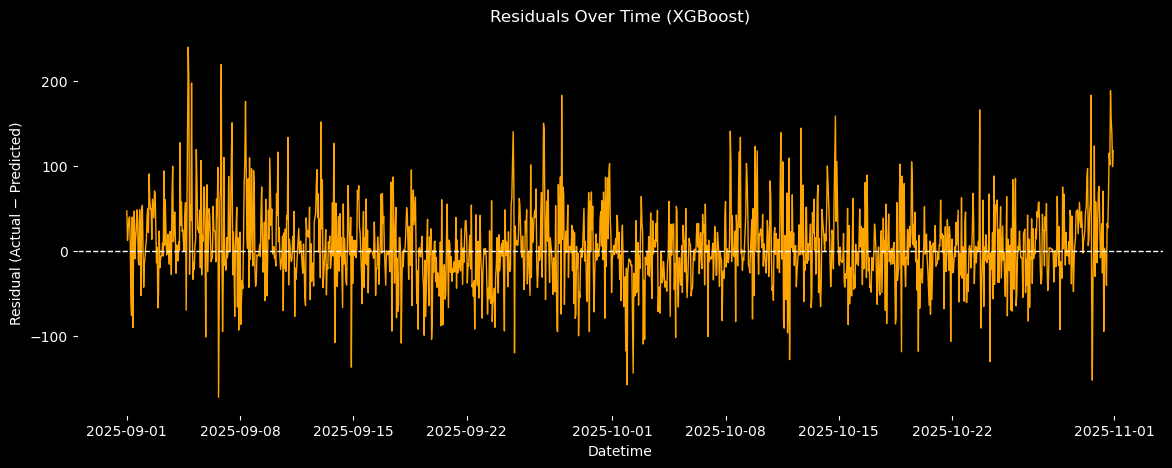

In [554]:
fig, ax = plt.subplots(figsize=(14,5))

ax.plot(residual_df.index, residual_df["Residual"], color="orange", linewidth=1)
ax.axhline(0, color="white", linestyle="--", linewidth=1)

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.set_title("Residuals Over Time (XGBoost)", color="white")
ax.set_ylabel("Residual (Actual − Predicted)", color="white")
ax.set_xlabel("Datetime", color="white")
ax.tick_params(colors="white")

# st.pyplot(fig)
plt.show()


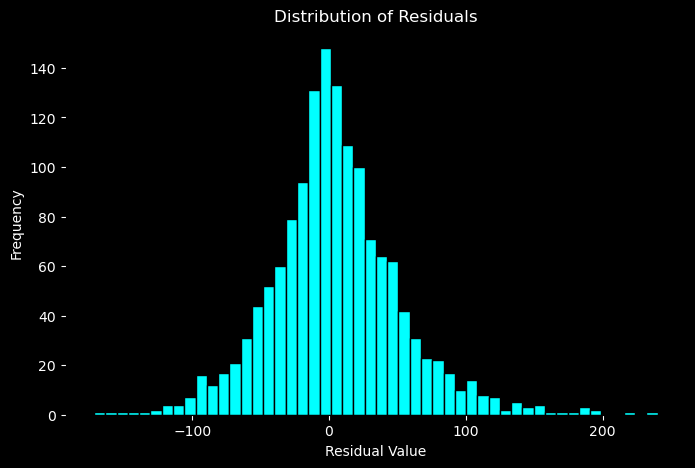

DeltaGenerator()

In [555]:
fig, ax = plt.subplots(figsize=(8,5))

ax.hist(residual_df["Residual"], bins=50, color="cyan", edgecolor="black")

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.set_title("Distribution of Residuals", color="white")
ax.set_xlabel("Residual Value", color="white")
ax.set_ylabel("Frequency", color="white")
ax.tick_params(colors="white")
plt.show()
st.pyplot(fig)


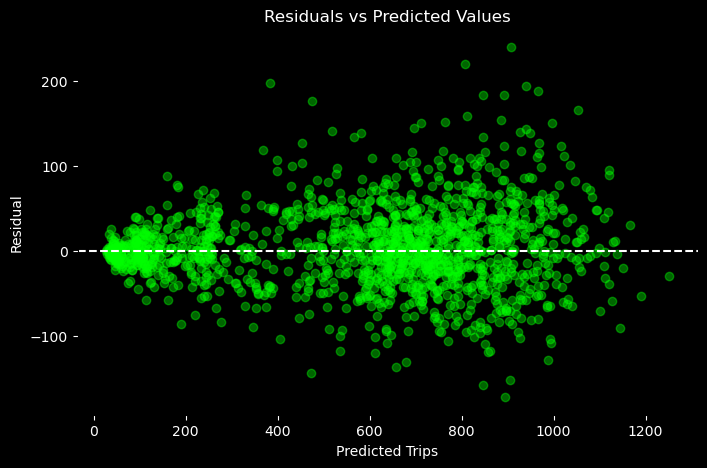

DeltaGenerator()

In [556]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(
    residual_df["Predicted"],
    residual_df["Residual"],
    alpha=0.4,
    color="lime"
)

ax.axhline(0, color="white", linestyle="--")

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.set_title("Residuals vs Predicted Values", color="white")
ax.set_xlabel("Predicted Trips", color="white")
ax.set_ylabel("Residual", color="white")
ax.tick_params(colors="white")
plt.show()
st.pyplot(fig)


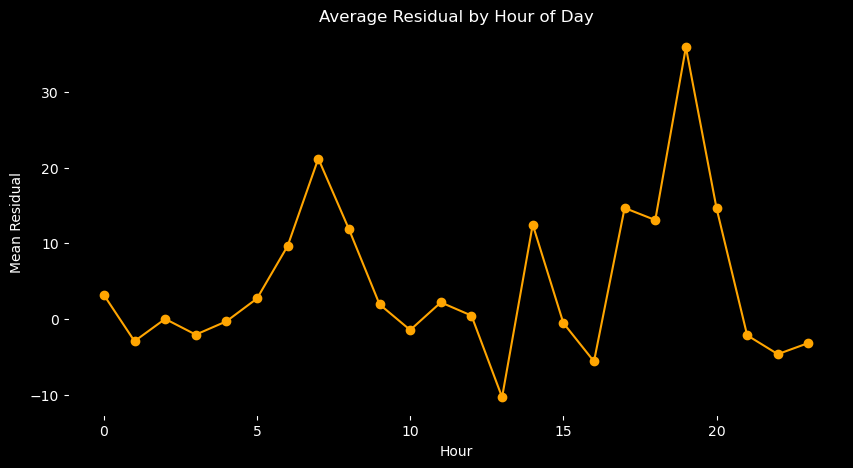

In [557]:
residual_df["Hour"] = residual_df.index.hour

hourly_residuals = residual_df.groupby("Hour")["Residual"].mean()

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(hourly_residuals.index, hourly_residuals.values, marker="o", color="orange")

fig.patch.set_facecolor("black")
ax.set_facecolor("black")

ax.set_title("Average Residual by Hour of Day", color="white")
ax.set_xlabel("Hour", color="white")
ax.set_ylabel("Mean Residual", color="white")
ax.tick_params(colors="white")

st.pyplot(fig)
plt.show()

In [558]:
importance = xgb_model.feature_importances_

In [559]:
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

In [560]:
feature_importance_df

,Feature,Importance
2,lag_168,0.606125
0,lag_1,0.228603
5,hour,0.040318
1,lag_24,0.039008
6,dayofweek,0.013964
12,is_festive_window,0.013107
4,rolling_std_24,0.012946
7,is_weekend,0.012545
11,is_holiday,0.011880
8,temp,0.006140


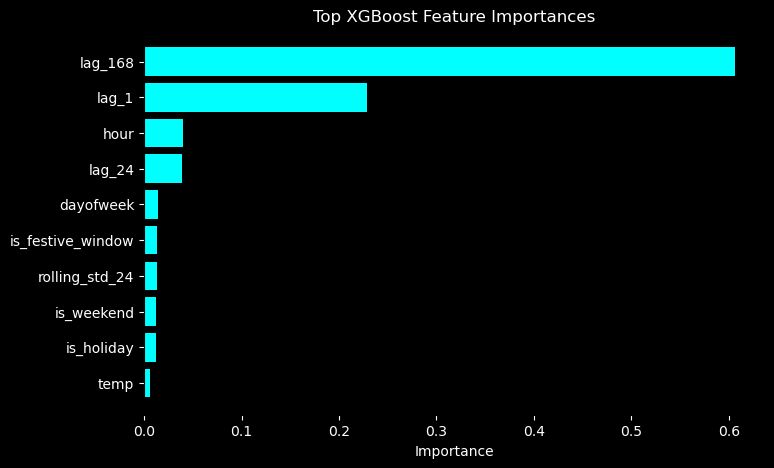

In [561]:
fig, ax = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

ax.barh(
    feature_importance_df["Feature"].head(10)[::-1],
    feature_importance_df["Importance"].head(10)[::-1],
    color='cyan'
)

ax.set_xlabel("Importance", color='white')
ax.set_title("Top XGBoost Feature Importances", color='white')
ax.tick_params(colors='white')

st.pyplot(fig)
plt.show()

In [562]:
residual_df

,Trips,Predicted,Residual,Hour
tpep_pickup_datetime,,,,
2025-09-01 00:00:00,437,389.398346,47.601654,0
2025-09-01 01:00:00,264,251.209244,12.790756,1
2025-09-01 02:00:00,189,161.736816,27.263184,2
2025-09-01 03:00:00,137,99.202332,37.797668,3
2025-09-01 04:00:00,132,91.405785,40.594215,4
...,...,...,...,...
2025-10-31 19:00:00,1155,965.857422,189.142578,19
2025-10-31 20:00:00,1041,886.297058,154.702942,20
2025-10-31 21:00:00,1089,949.352783,139.647217,21


In [563]:
top_zones = residual_df.sort_values(
    by="Predicted", ascending=False
).head(10)


In [564]:
top_zones

,Trips,Predicted,Residual,Hour
tpep_pickup_datetime,,,,
2025-10-23 18:00:00,1223,1251.624023,-28.624023,18
2025-10-09 18:00:00,1138,1190.176636,-52.176636,18
2025-09-18 18:00:00,1197,1165.805298,31.194702,18
2025-09-10 18:00:00,1131,1151.093750,-20.093750,18
2025-10-23 19:00:00,1053,1143.275757,-90.275757,19
2025-09-19 18:00:00,1135,1138.203857,-3.203857,18
2025-09-11 18:00:00,1146,1133.948486,12.051514,18
2025-10-16 19:00:00,1141,1129.902954,11.097046,19
2025-10-22 18:00:00,1069,1127.685913,-58.685913,18


In [567]:
# Example pickup locations (lat, lon)
coords = np.array([
    [40.7580, -73.9855],  # Times Square
    [40.7128, -74.0060],  # Lower Manhattan
    [40.7306, -73.9352],  # Brooklyn
    [40.7527, -73.9772],  # Midtown East
    [40.7061, -74.0086]   # Wall Street
])


In [572]:
from scipy.spatial.distance import cdist

distance_matrix = cdist(coords, coords, metric='euclidean')
def greedy_route(dist_matrix, start=0):
    n = dist_matrix.shape[0]
    visited = [start]

    while len(visited) < n:
        last = visited[-1]
        next_city = np.argmin([
            dist_matrix[last, j] if j not in visited else np.inf
            for j in range(n)
        ])
        visited.append(next_city)

    return visited



In [573]:
distance_matrix = cdist(coords, coords, metric='euclidean')

In [574]:
optimization_df = greedy_route(distance_matrix, start=0)

In [575]:
optimization_df

[0, 3, 2, 1, 4]

In [576]:
route = greedy_route(distance_matrix, start=0)